In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 32.8 MB/s eta 0:00:00


In [ ]:
!pip install keras-balanced-batch-generator

In [ ]:
# Libraries for data preprocessing and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for working with text data
import gensim
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

# Libraries for building and training deep learning models
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
#from torchtext.data.functional import to_map_style_dataset # This import should work now
from torchmetrics.classification import BinaryF1Score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import load_model
from tensorflow.keras.utils import plot_model
from keras_balanced_batch_generator import make_generator

# Libraries for model evaluation and metrics
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Miscellaneous libraries
import os
import json
import time
import gc
import random
import warnings
warnings.filterwarnings('ignore')
import re
import string
from typing import Dict
from IPython.display import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Step 2: Import required libraries
import zipfile
import os

Mounted at /content/drive


In [ ]:
# Step 3: Define the path to the zip file
zip_file_path = '/content/zesecured_model.zip'

# Step 4: Define the extraction directory
folder_path = '/content/Dis_information'

In [ ]:
# Step 5: Import the 'os' module
import os # Import the os module to interact with the operating system

# Step 6: Create the extraction directory if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Import the zipfile module
import zipfile

# Step 7: Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path)

print(f'Files extracted to {folder_path}')

Files extracted to /content/Dis_information


In [ ]:
df = pd.read_json('/content/Dis_information/politifact_factcheck_data.json', lines=True)

In [ ]:
df.head()

,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link
0,true,Barack Obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,Adriel Bettelheim,6/16/2008,https://www.politifact.com/factchecks/2008/jun...
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,Yacob Reyes,6/13/2022,https://www.politifact.com/factchecks/2022/jun...
2,mostly-true,Kelly Ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,Clay Wirestone,5/27/2016,https://www.politifact.com/factchecks/2016/may...
3,false,Bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,Madison Czopek,2/5/2021,https://www.politifact.com/factchecks/2021/feb...
4,half-true,Bobby Jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,Linda Qiu,8/30/2015,https://www.politifact.com/factchecks/2015/aug...


In [ ]:
df.shape

(21152, 8)

In [ ]:
df.verdict.value_counts()

,count
verdict,
false,5625
half-true,3597
mostly-false,3432
mostly-true,3332
pants-fire,2703
true,2463


In [ ]:
# Convert to datetime data type
df['statement_date'] = pd.to_datetime(df['statement_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21152 entries, 0 to 21151
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   verdict                  21152 non-null  object        
 1   statement_originator     21152 non-null  object        
 2   statement                21152 non-null  object        
 3   statement_date           21152 non-null  datetime64[ns]
 4   statement_source         21152 non-null  object        
 5   factchecker              21152 non-null  object        
 6   factcheck_date           21152 non-null  object        
 7   factcheck_analysis_link  21152 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 1.3+ MB


In [ ]:
# function to print rows of the dataframe
def print_row(input_df: pd.DataFrame, index: int) -> None:
    """Most relevant columns for today's analysis"""
    print(f"speaker: {input_df.iat[index, 1]}")
    print(f"statement: {input_df.iat[index, 2]}")
    print(f"label: {input_df.iat[index, 0]}")

In [ ]:
print_row(df, 1)

speaker: Matt Gaetz
statement: "Bennie Thompson actively cheer-led riots in the ’90s."
label: false


In [ ]:
print_row(df, 324)

speaker: Patrick Lynch
statement: "Deepwater's own testimony . . . is they said they'll create six jobs."
label: half-true


# Exploratory Data Analysis(EDA)
All of the dataset's columns are of type object. Most of the them are metadata related to the statement. We will explore both the metadata and the statement column (which contains the text of the statement) to see if we can find some pattern that helps us predict the verdict of a given data point.
With a pandas.DataFrame in hand, we can start asking questions about the data. This is called "Exploratory Data Analysis" (a.k.a. "EDA") and is a critical step in a data scientist's workflow. It is important because we need to understand the nature of our data in order to draw conclusions from it. Some questions we'll answer today,

What is the distribution of labels in this data? How many "mostly-true", "half-true", etc?
How many distinct subjects are there? Distinct speakers?

In [ ]:
# This function plots a countplot with percentages
def plot_sns_chart(dataframe, y_axis, class_separator=None, width=20.0, height=9.0,
                   font_scale=2, title = 'Title has not been set',
                   xlabel_title="Xlabel title not been set", ylabel_title="Ylabel title not been set",
                   colors=None):
    plt.rcParams['figure.figsize'] = [width, height]
    plt.legend(['Legend'], loc='right')
    sns.set(font_scale=font_scale)
    g = sns.countplot(y=y_axis, hue=class_separator, data=dataframe, palette=colors)
    g.set(xlabel=xlabel_title, ylabel=ylabel_title)
    g.set_title(title)
    total = float(len(dataframe))
    margin = 0.0025
    for patch in g.patches:
        percentage = ' {:.1f}%'.format(100 * patch.get_width() / total)
        x = patch.get_width() + (patch.get_width() * margin)
        y = patch.get_y() + (patch.get_height() / 2)
        g.annotate(percentage, (x, y), va='center')

colors_verdict = {'pants-fire': "#ea5545",
                  'false': "#f46a9b",
                  'mostly-false': "#ef9b20",
                  'half-true': "#edbf33",
                  'mostly-true': "#ede15b",
                  'true': "#bdcf32"
                 }

## Label Distribution & "Truthiness"
These definitions were taken from PolitiFact's "truth-o-meter" methodology page

1. true – The statement is accurate and there’s nothing significant missing.
2. mostly-true – The statement is accurate but needs clarification or additional information.
3. half-true – The statement is partially accurate but leaves out important details or takes things out of context.
4. barely-true – The statement contains an element of truth but ignores critical facts that would give a different impression.
5. false – The statement is not accurate.
6. pants-fire – The statement is not accurate and makes a ridiculous claim. a.k.a. "Liar, Liar, Pants on Fire!"



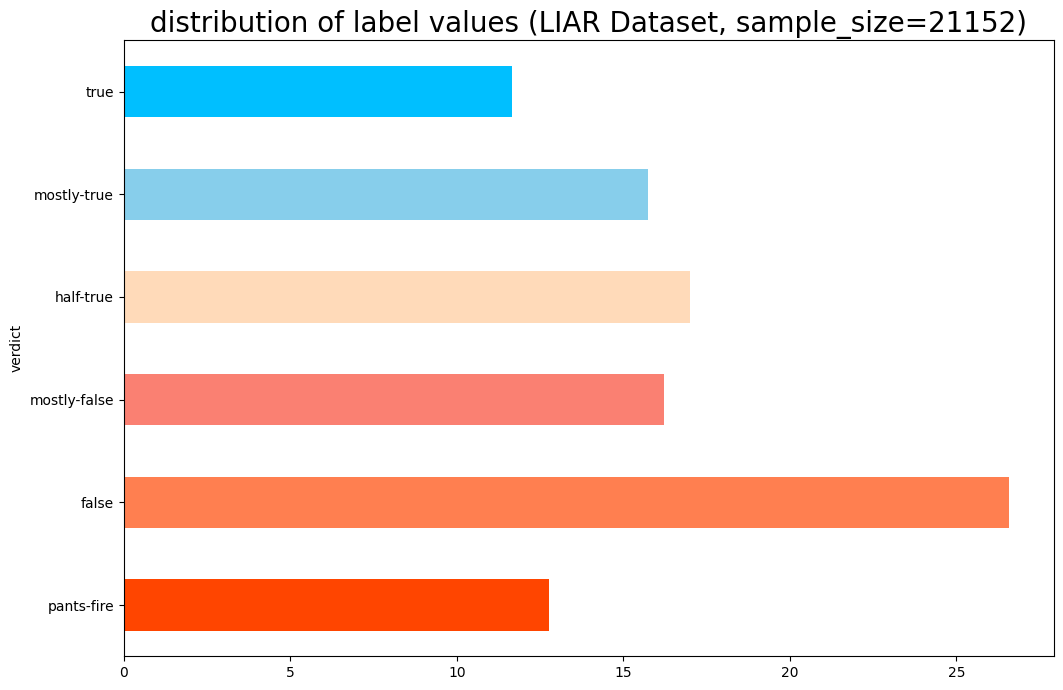

In [ ]:
def label_bar_chart(input_df: pd.DataFrame, title: str = "LIAR Dataset") -> None:

    # computes frequencies of labels and converts to percentages
    label_frequencies = input_df['verdict'].value_counts(normalize=True)

    def multiply_100(x):
        return x * 100

    # "apply" is a handy way to call a function on every row of data.
    label_frequencies = label_frequencies.apply(multiply_100)

    # bar chart ordering and  colors for readability.
    labels = ['pants-fire', 'false', 'mostly-false', 'half-true', 'mostly-true', 'true']
    colors = [
        'orangered', # pants-fire
        'coral', # false
        'salmon', # barely-true
        'peachpuff', # half-true
        'skyblue', # mostly-true
        'deepskyblue' # true
    ]

    label_frequencies = label_frequencies.reindex(index = labels)


    # creates a horizontal bar chart with a descriptive title
    axis = label_frequencies.plot(kind='barh', figsize=(12, 8), color=colors)
    axis.set_title(f"distribution of label values ({title}, sample_size={len(input_df)})", size=20);

label_bar_chart(df)


# Speaker Analysis
Let's take a look at the speaker column now. In order for this data to be super useful, we want a large breadth of speakers. Otherwise, the dataset might be too narrow for general applicability. It might also be nice to look at label distribution for a given speaker.

pandas has a lot of builtin methods to help slice and dice datasets. pandas.Series.nunique() gives us the number of unique values for a column. We can treat pandas.DataFrame like a list and call len(df) to get the total number of rows.

In [ ]:
num_unique_speakers = df['statement_originator'].nunique()
avg_statments = len(df) / num_unique_speakers

print(f"Unique speakers in dataset: {num_unique_speakers}")
print(f"Average statements made per speaker: {avg_statments}")

Unique speakers in dataset: 4565
Average statements made per speaker: 4.633515881708653


We can filter a pandas.DataFrame by specific values. However, it uses non-native python syntax which can look pretty foreign at first,

In [ ]:
# function to print the top n speakers by number of statements
def speaker_bar_chart(input_df: pd.DataFrame, speaker: str) -> pd.DataFrame:

    # filters the input_df
    speaker_df = input_df[ input_df['statement_originator'] == speaker ]
    speaker_df.reset_index(inplace=True)

    # calls the bar chart function we created earlier
    label_bar_chart(speaker_df, title=speaker)

    return speaker_df

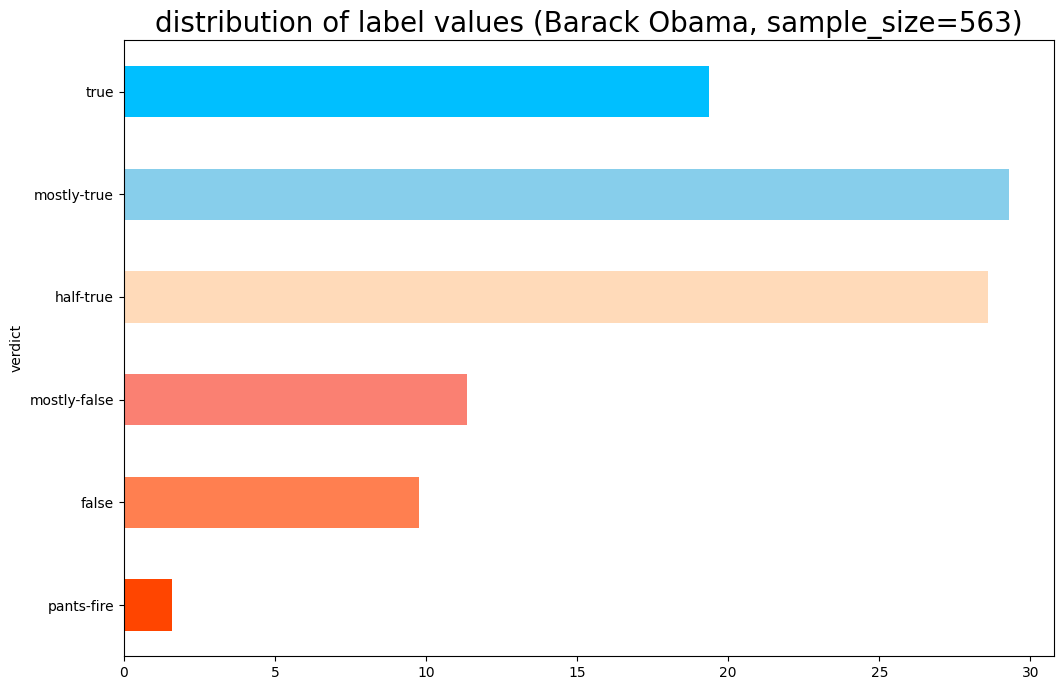

In [ ]:
ret_df = speaker_bar_chart(df, 'Barack Obama')

### Distribution of verdict

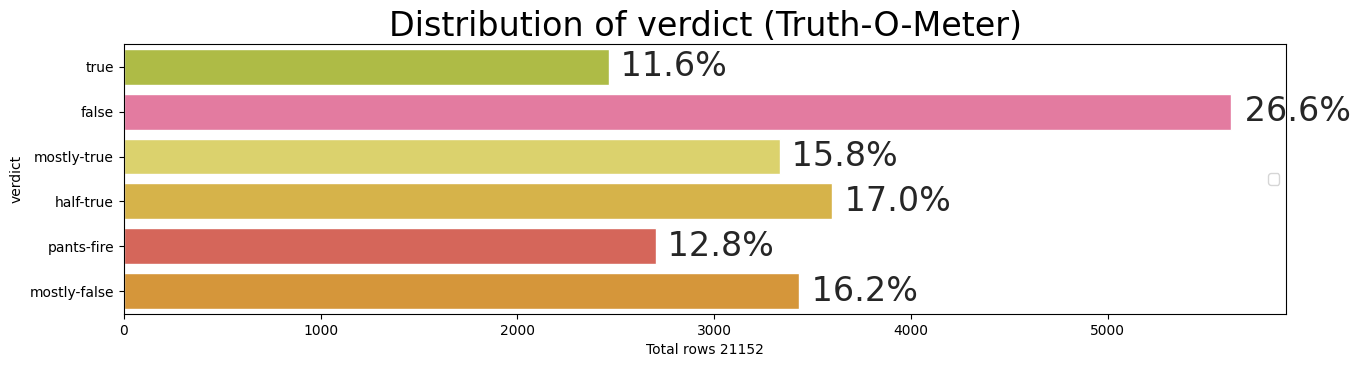

In [ ]:
plot_sns_chart(df, 'verdict', width=15.0, height=3.5,
               title=f'Distribution of verdict (Truth-O-Meter)',
               ylabel_title='verdict',
               xlabel_title=f'Total rows {df.shape[0]}',
               colors=colors_verdict)

The Politifact dataset contains more false statements than other types of verdicts. About 27% of the statements are false and only 11.5% are true. The rest of the statements have some level of either truthness or falseness.

### What's the distribution of verdict if we only consider all statements to be either true or false?


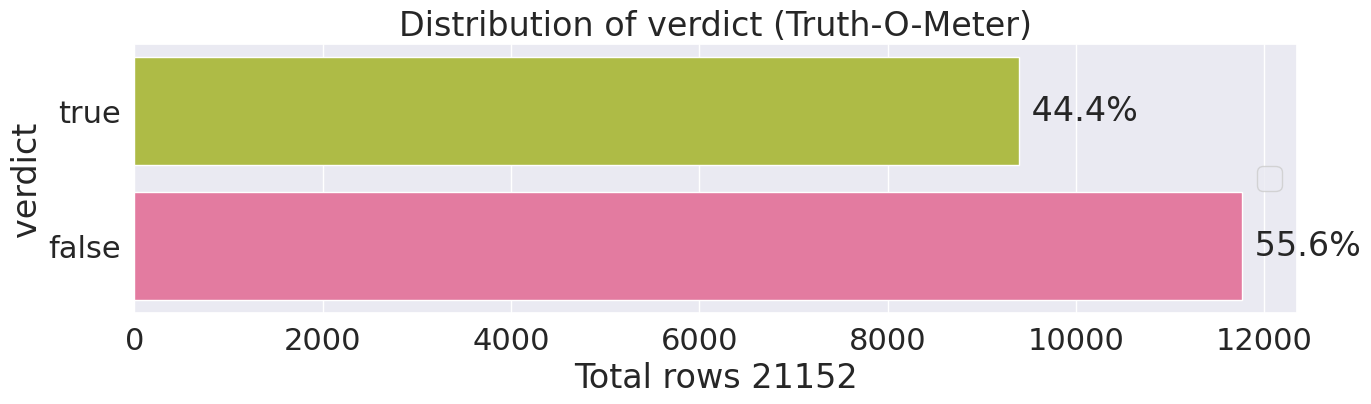

In [ ]:
#What's the distribution of verdict if we only consider all statements to be either true or false?
ver_df = df['verdict'].replace(['pants-fire', 'false', 'mostly-false'], 'false')
ver_df = ver_df.replace(['half-true', 'mostly-true', 'true'], 'true')

#add column name to the series
ver_df = ver_df.to_frame(name='verdict')
plot_sns_chart(ver_df, 'verdict', width=15.0, height=3.5,
                title=f'Distribution of verdict (Truth-O-Meter)',
                ylabel_title='verdict',
                xlabel_title=f'Total rows {df.shape[0]}',
                colors=colors_verdict)

The plot above tells us that this dataset contains more false statements (55.6%). However, the daset also contains 44% of true statements (about 9% difference with false statements).

### What is the source of the statements?

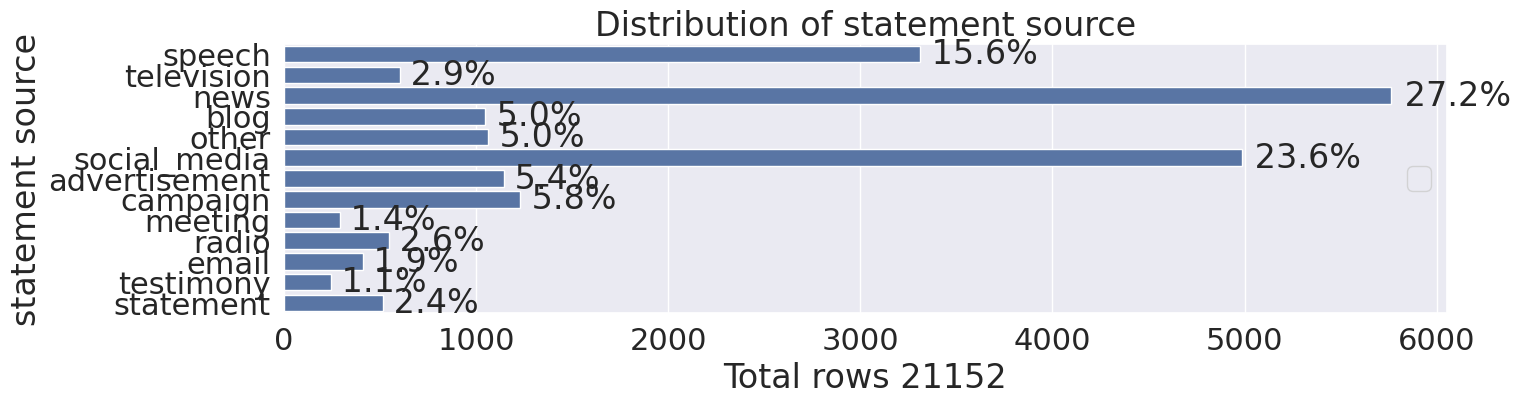

In [ ]:
# What is the source of the statements?
plot_sns_chart(df, 'statement_source', width=15.0, height=3.5,
                title=f'Distribution of statement source',
                ylabel_title='statement source',
                xlabel_title=f'Total rows {df.shape[0]}')


Most of the statements come from either news (27.2%), social media (23.6%), or speech (15.6%). The rest of the statements come from various sources such as blog posts, campaigns, and advertisements, among others.

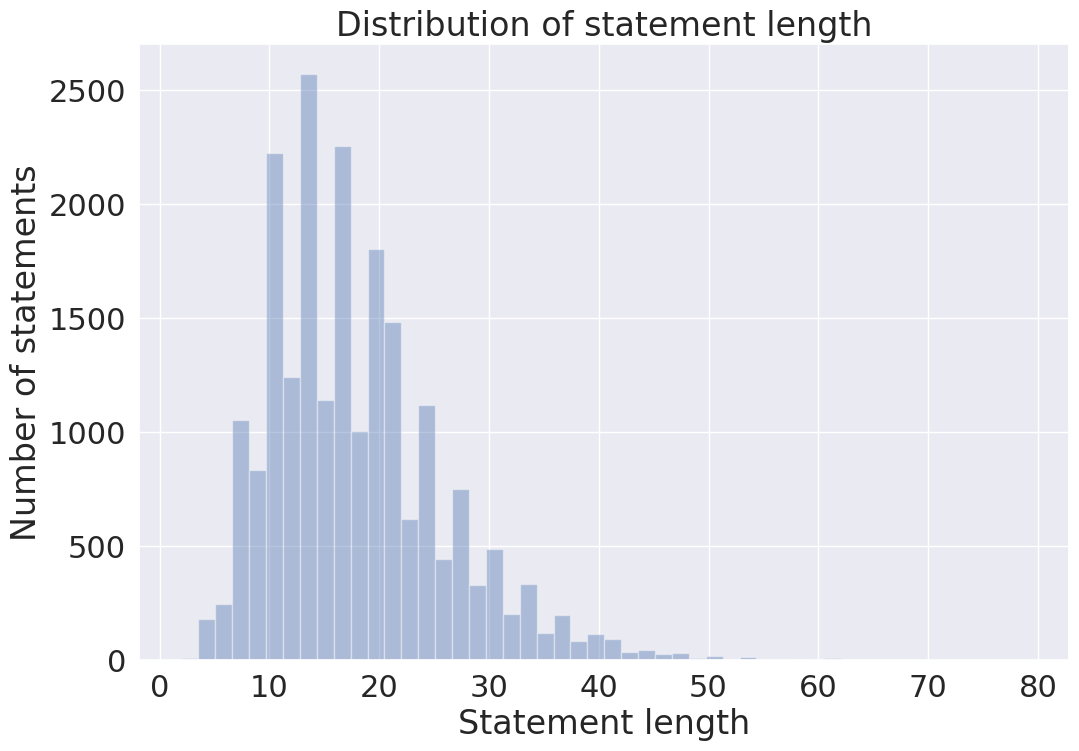

In [ ]:
# Statement length¶
# Now, we turn our attention to the statement column (text) that has the actual statement that was submitted to Politifact for fact-checking:
# Let's see the distribution of the length of the statements
df['statement_length'] = df['statement'].apply(lambda x: len(x.split()))
df['statement_length'].describe()
# plot a histogram to see the distribution of the length of the statements
plt.figure(figsize=(12, 8))
sns.distplot(df['statement_length'], kde=False)
plt.title('Distribution of statement length')
plt.xlabel('Statement length')
plt.ylabel('Number of statements')
plt.show()

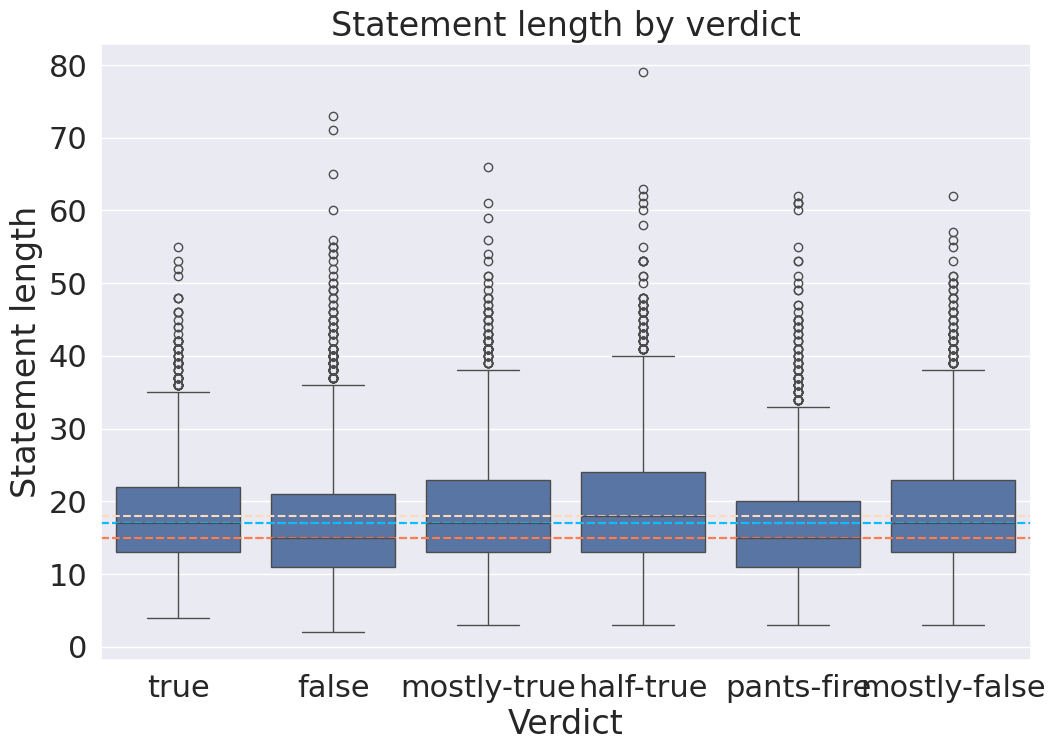

In [ ]:
# Statement length by verdict using a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='verdict', y='statement_length', data=df)
plt.title('Statement length by verdict')
plt.xlabel('Verdict')
plt.ylabel('Statement length')
#plot vertical lines to show the median
plt.axhline(df[df['verdict'] == 'pants-fire']['statement_length'].median(), color='orangered', linestyle='--')
plt.axhline(df[df['verdict'] == 'false']['statement_length'].median(), color='coral', linestyle='--')
plt.axhline(df[df['verdict'] == 'mostly-false']['statement_length'].median(), color='salmon', linestyle='--')
plt.axhline(df[df['verdict'] == 'half-true']['statement_length'].median(), color='peachpuff', linestyle='--')
plt.axhline(df[df['verdict'] == 'mostly-true']['statement_length'].median(), color='skyblue', linestyle='--')
plt.axhline(df[df['verdict'] == 'true']['statement_length'].median(), color='deepskyblue', linestyle='--')
plt.show()

### Emotion analysis


In [ ]:
# emotion analysis of the statements
#get the emotion from the text in 5 categories
from textblob import TextBlob

def get_emotion(text):
    emotion_list=[]
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        emotion_list.append(str('positive'))
    elif analysis.sentiment.polarity == 0:
        emotion_list.append(str('neutral'))
    else:
        emotion_list.append(str('negative'))
    return emotion_list


In [ ]:
#apply the function to the statement column
emotion = df['statement'].apply(get_emotion)
# get only str from the list
emotion = emotion.apply(lambda x: x[0])


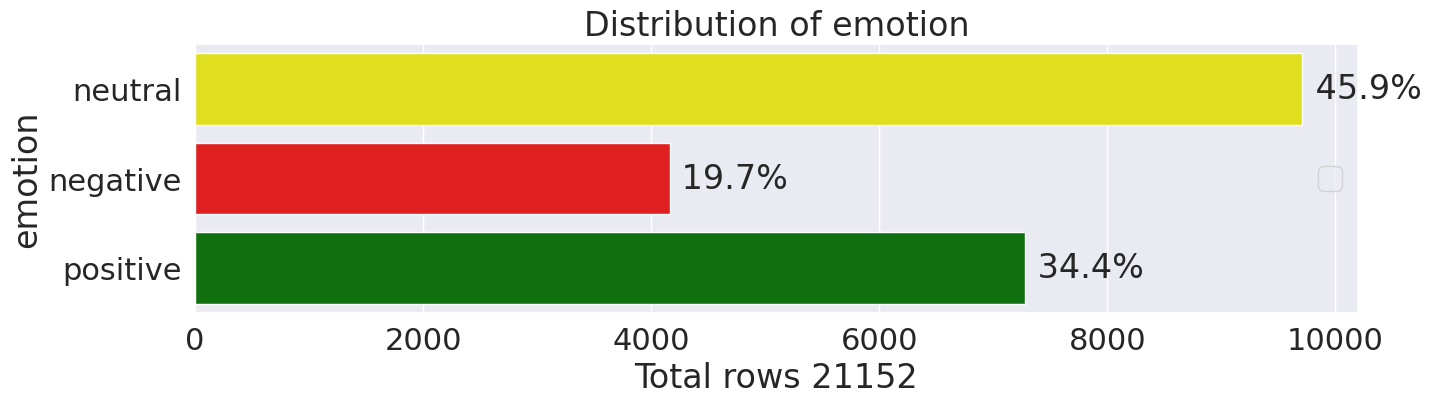

In [ ]:
emotion_df = emotion.to_frame(name='emotion')
plot_sns_chart(emotion_df, 'emotion', width=15.0, height=3.5,
                title=f'Distribution of emotion',
                ylabel_title='emotion',
                xlabel_title=f'Total rows {df.shape[0]}',
                colors= {'positive': 'green', 'neutral': 'yellow', 'negative': 'red'})

### Entity recognition analysis
We turn to entity recognition analysis so we can understand who are the entities mentioned in statements. To obtain all the entities we use SpaCy to perform entity analysis.

## Key findings from EDA
In summary, the Politifact dataset has the following key characteristics:

It has 21152 data points and includes metadata and text data. It has the following columns :

* verdict

* statement_originator

* statement

* statement_date

* statement_source

* fact-checker

* factcheck_date

* factcheck_analysis_link

It has no missing data.

It contains more false statements than other types of verdicts. About 27% of the statements are false and only 11.5% are true. The rest of the statements have some level of either truthness or falseness.
The majority of social media (Facebook posts, viral images, and Instagram posts) statements are false (57.7% of false and 24.6% pants of fire).

# Modeling

In [ ]:
# Binarize the labels
binary_map = {
    'true': 1,
    'mostly-true': 1,
    'half-true': 1,
    'mostly-false': 0,
    'false': 0,
    'pants-fire': 0
}

df['binary_verdict'] = df['verdict'].map(binary_map)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import en_core_web_sm
nlp = en_core_web_sm.load()
random_state = 42

In [ ]:
# Clean the dataset
def clean_text(text):
    '''Make text lowercase, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('.*?¿', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r" +", " ", text)
    return text

def remove_stop_words(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop]
    return " ".join(token for token in tokens)

def remove_spaces(text):
    text = re.sub(r" +", " ", text)
    return text

In [ ]:
df['cleaned_statement'] = df['statement'].apply(clean_text)
df['cleaned_statement'] = df['cleaned_statement'].apply(remove_stop_words)
df['cleaned_statement'] = df['cleaned_statement'].apply(remove_spaces)

In [ ]:
# get the sample dataset
class PolitifactDataset(Dataset):
    def __init__(self, text, labels):
        self.labels = labels.values
        self.text = text.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.text[idx]
        sample = (label, text)
        return sample

In the above code snippet defines a custom PyTorch dataset called PolitifactDataset, which is used for loading a sample dataset consisting of text and corresponding labels. The dataset is initialized with two parameters, text and labels, which are assumed to be Pandas series containing the text and labels of the dataset.

In [ ]:
dataset = PolitifactDataset(df["cleaned_statement"],
                            df["binary_verdict"])

In [ ]:
print('\nFirst element of dataset: ', next(iter(dataset)), '\n')
print('Length of dataset: ', len(dataset), '\n')


First element of dataset:  (1, 'john mccain opposed bankruptcy protections families bankruptcy medical expenses nt pay') 

Length of dataset:  21152 



In [ ]:

!pip uninstall torch torchtext

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchfrtrace
    /usr/local/bin/torchrun
    /usr/local/lib/python3.10/dist-packages/functorch/*
    /usr/local/lib/python3.10/dist-packages/torch-2.5.1+cu121.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torch/*
    /usr/local/lib/python3.10/dist-packages/torchgen/*
Proceed (Y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/uninstall.py", line 106, in run
    uninstall_pathset = req.uninstall(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_install.py", line 722, in uninstall
    uninstalled_pathset.remove(auto_confirm, 

In [ ]:
!pip install torch==2.5.1+cu121
!pip install torchtext==0.15.0


ERROR: Could not find a version that satisfies the requirement torchtext==0.15.0 (from versions: 0.1.1, 0.2.0, 0.2.1, 0.2.3, 0.3.1, 0.4.0, 0.5.0, 0.6.0, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0)
ERROR: No matching distribution found for torchtext==0.15.0


In [ ]:
!python --version


Python 3.10.12


In [ ]:
!python -m venv myenv


The virtual environment was not created successfully because ensurepip is not
available.  On Debian/Ubuntu systems, you need to install the python3-venv
package using the following command.

    apt install python3.10-venv

You may need to use sudo with that command.  After installing the python3-venv
package, recreate your virtual environment.

Failing command: /content/myenv/bin/python3



In [ ]:
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

ModuleNotFoundError: No module named 'torchtext'

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [ ]:
!pip install torchtext --upgrade

In [ ]:
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

In [ ]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

In [ ]:
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [ ]:
num_class = len(set([label for (label, text) in dataset]))
vocab_size = len(vocab)
emsize = 32
model = TextClassificationModel(vocab_size, emsize, num_class)

In [ ]:
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()
    accu_list = []
    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            accu_list.append(total_acc/total_count)
            total_acc, total_count = 0, 0
            start_time = time.time()
    print(' ')
    print('Maximum Training Accuracy: ',(max(accu_list)*100))
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [ ]:
train_dataset, test_dataset = random_split(dataset,
                                           [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))],
                                           generator=torch.Generator().manual_seed(random_state))

train_dataset = to_map_style_dataset(train_dataset)
test_dataset = to_map_style_dataset(test_dataset)

num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=8, shuffle=False, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=8, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [ ]:
EPOCHS = 10 # epoch
LR = 0.1  # learning rate
BATCH_SIZE = 32  # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

In [ ]:
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()
    accu_list = []
    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        # Iterate through parameters and clip gradients individually
        for param in model.parameters():
            if param.grad is not None:
                if param.grad.is_sparse:
                    # Handle sparse gradients separately
                    param.grad = param.grad.coalesce()  # Coalesce sparse gradients
                    torch.nn.utils.clip_grad_norm_(param.grad, 0.1)
                else:
                    # Clip dense gradients
                    torch.nn.utils.clip_grad_norm_(param, 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            accu_list.append(total_acc/total_count)
            total_acc, total_count = 0, 0
            start_time = time.time()
    print(' ')
    print('Maximum Training Accuracy: ',(max(accu_list)*100))

# Neural Network Model with LSTM

In [ ]:
def get_network(X, network = None,voc_size=10000, embed_dim=40, dropout=0.5, sent_length=5000, lstm_out=100, go_backwards = False):
    model = Sequential()
    model.add(Embedding(voc_size, embed_dim, input_length=sent_length))
    model.add(Dropout(dropout))
    if(go_backwards):
        model.add(Bidirectional(LSTM(lstm_out)))
    else:
        model.add(LSTM(lstm_out))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    print(model.summary())

    if(network):
        print('loading weights...')
        model.load_weights(network)
    return model

### Below model have more layers so you can also use that

In [ ]:
# def get_network(X, network=None, voc_size=10000, embed_dim=40, dropout=0.5, sent_length=5000, lstm_out=100, go_backwards=False):
#     model = Sequential()
#     model.add(Embedding(voc_size, embed_dim, input_length=sent_length))
#     model.add(Dropout(dropout))
#     if(go_backwards):
#         model.add(Bidirectional(LSTM(lstm_out, return_sequences=True)))
#     else:
#         model.add(LSTM(lstm_out, return_sequences=True))
#     model.add(Dropout(dropout))
#     model.add(LSTM(lstm_out))
#     model.add(Dropout(dropout))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     print(model.summary())

#     if(network):
#         print('loading weights...')
#         model.load_weights(network)
#     return model


In [ ]:
def bar_plot(data):

    # Draw a nested barplot by species and sex
    ax = sns.countplot(x="type", hue="fake", data=data)

def show_wordcloud(df):
    text = ''
    for news in df.text.values:
        text += f" {news}"
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    del text

def show_training(hist):
    history = hist.history
    n = len(history['accuracy'])

    plt.subplot(211)

    X = [x for x in range(1,n+1)]
    _ = plt.plot(X, history['accuracy'], '-', label='train acc')
    _ = plt.plot(X, history['val_accuracy'], '-', label =  'val acc')
    _ = plt.legend()


    plt.subplot(212)
    _ = plt.plot(X, history['loss'], '--', label = 'train loss')
    _ = plt.plot(X, history['val_loss'], '--', label = 'val loss')
    _ = plt.legend()

    plt.show()

In [ ]:
def token_to_embedding(corpus, voc_size, sent_length=5000):
    #from list to string
    corpus = [' '.join(sentence) for sentence in corpus]

    #from string to one-hot representation
    onehot = [one_hot(words,voc_size)for words in corpus]

    #from one-hot representation to embeddings by using padding
    embeddings=pad_sequences(onehot,padding='pre',maxlen=sent_length)
    print(embeddings)


    return embeddings

In [ ]:
data = pd.DataFrame()
data['verdict'] = df['verdict']
data['text'] = df['cleaned_statement']
data.head()

### here we map the data into two classes "True and False"

In [ ]:
# Binarize the labels
binary_map = {
    'true': 1,
    'mostly-true': 1,
    'half-true': 1,
    'mostly-false': 0,
    'false': 0,
    'pants-fire': 0
}
data['verdict'] = data['verdict'].map(binary_map)

In [ ]:
X = data.text.values
y = data.verdict.values

In [ ]:
stemming = False
voc_size=10000
sent_length = 500
lstm_out= 100
embed_dim = 100
dropout = 0.3
go_backwards=True

network = None

#data
validation_size = 0.1
test_size = 0.15

#training
batch_size = 128
steps_per_epoch = 64
n_epochs = 5

In [ ]:
print('Tokenizing the data...')
corpus = X_stemmed if stemming else X
# test = X_stemmed_test if stemming else X_test
X = np.array(token_to_embedding(corpus=corpus, voc_size=voc_size, sent_length=sent_length))
# X_test = np.array(token_to_embedding(corpus=test, voc_size=voc_size, sent_length=sent_length))
print(f'X shape: {X.shape}\ny shape: {y.shape}')

In [ ]:
print('training the network...')
model = get_network(X, network=network, dropout=dropout, embed_dim=embed_dim,sent_length=sent_length,voc_size=voc_size, lstm_out=lstm_out, go_backwards=go_backwards)
# DATA #
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = test_size)

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [ ]:
# let's visualize the layes of Neural network with lstm
# Call the model on a batch of data to build it before plotting
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size)
# Assuming X_train and y_train are your training data
model(X_train[:1])  # Call the model on a single batch to build it
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
for layer in model.layers:
    # Accessing input shape using layer.input.shape for compatibility
    input_shape = layer.input.shape if hasattr(layer, 'input') else 'N/A'
    # Accessing output shape using layer.output.shape for compatibility
    output_shape = layer.output.shape if hasattr(layer, 'output') else 'N/A'
    print(f"Input shape: {input_shape}. Output shape: {output_shape}")

In [ ]:
if(not network):
    print('let\'s train...')
    n_epochs = n_epochs
    y_train = to_categorical(y_train)
    #y_test = to_categorical(y_test)

    generator = make_generator(X_train, y_train, batch_size, categorical=False)

    #hist = model.fit(generator, steps_per_epoch = steps_per_epoch, epochs = n_epochs,  verbose = 5)
    hist = model.fit(
        generator,
        steps_per_epoch=steps_per_epoch,
        epochs = n_epochs,
        verbose=1,
        validation_data=(X_val, y_val)
    )
    model.save("10_epochs.h5")

In [ ]:
show_training(hist)

In [ ]:
#credits: https://www.kaggle.com/benroshan/fake-news-classifier-lstm
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
y_pre=model.predict(X_val)
y_pre

In [ ]:
y_pred = np.where(y_pre >= 0.5, 1, 0)
y_pred

In [ ]:
print('Accuracy: ',100*(accuracy_score(y_val,y_pred)))
print('  ')
cm = metrics.confusion_matrix(y_val, y_pred)
plot_confusion_matrix(cm,classes=['True','Fake'])
print("Classification Report:\n",classification_report(y_val, y_pred))

In [ ]:
#credits: https://www.kaggle.com/benroshan/fake-news-classifier-lstm

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

model = load_model("10_epochs.h5")
tokenizer = Tokenizer(num_words=10000)
# Preprocessing and prediction function
def preprocess_and_predict(model, text, tokenizer, max_len=5000):

    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)

    prediction = model.predict(padded_sequence)

    if prediction[0] > 0.3:
        return "The news is likely to be TRUE."
    else:
        return "The news is likely to be FAKE."



In [ ]:
# Interactive system
def interactive_fake_news_detection():
    print("Welcome to the Fake News Detection System!")
    print("Enter a news sentence or paragraph to check if it's true or fake:")

    while True:
        user_input = input("Enter text (or type 'exit' to quit): ")

        if user_input.lower() == 'exit':
            print("Exiting the Fake News Detection System.")
            break

        # Predict and display the result
        result = preprocess_and_predict(model, user_input, tokenizer)
        print(result)

# Run the interactive system
interactive_fake_news_detection()